# 70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．

In [ ]:
'''３データを持ってくる
tokenizeする
単語の特徴量をとる
平均をとる
xiができる
Xを作る
Yを作る'''
import pandas as pd
import numpy as np
import re
from collections import Counter
from tqdm import tqdm
from gensim.models import KeyedVectors
tqdm.pandas()
googlenews = KeyedVectors.load_word2vec_format(
    '../../data/GoogleNews-vectors-negative300.bin', binary=True)


In [ ]:
d = 300  # 単語ベクトルの次元

# TODO np.zerosを使う

def preprocessor(doc):
    doc = re.sub(r"[',.]", '', doc)     # 記号を削除
    doc = doc.lower()             # 小文字に統一
    return doc


def tokenize(doc):
    tokens = doc.split(' ')
    return tokens


def emb(token):
    if token in googlenews:
        return googlenews[token]
    else:
        return [0.0]*d


def get_x(tokens): # t = 0 の場合ここでnanが出てしまっていた．
    t = len(tokens)
    x = np.array([0.0]*d)
    if t == 0:
        return x
    for token in tokens:
        x += np.array(emb(token))
    return x/t


def reduce_vocab(tokens):
    tokens = [token for token in tokens if token in googlenews]
    return tokens


def is_empty(tokens):
    return len(tokens) == 0


def bag_of_tokens(doc):
    vector = [0]*len(vocab)
    for token in doc:
        if token in vocab:
            vector[vocab.index(token)] += 1
    return pd.Series(vector)




In [ ]:
columns = ('category', 'title')
train = pd.read_csv('../../data/NewsAggregatorDataset/train.txt',
                    names=columns, sep='\t')
valid = pd.read_csv('../../data/NewsAggregatorDataset/valid.txt',
                    names=columns, sep='\t')
test = pd.read_csv('../../data/NewsAggregatorDataset/test.txt',
                   names=columns, sep='\t')
print(len(train))
# preprocess
train['tokens'] = train.title.progress_apply(preprocessor)
test['tokens'] = test.title.progress_apply(preprocessor)
valid['tokens'] = valid.title.progress_apply(preprocessor)

# tokenize
train['tokens'] = train.tokens.apply(tokenize)
test['tokens'] = test.tokens.apply(tokenize)
valid['tokens'] = valid.tokens.apply(tokenize)

# reduce vocablary
train['tokens'] = train.tokens.apply(reduce_vocab)
test['tokens'] = test.tokens.apply(reduce_vocab)
valid['tokens'] = valid.tokens.apply(reduce_vocab)

train['is_empty'] = train.tokens.apply(is_empty)
test['is_empty'] = test.tokens.apply(is_empty)
valid['is_empty'] = valid.tokens.apply(is_empty)

train = train[train.is_empty == False]
test = test[test.is_empty == False]
valid = valid[valid.is_empty == False]


In [ ]:
X_train = np.array(train.tokens.apply(get_x).values.tolist())
X_valid = np.array(valid.tokens.apply(get_x).values.tolist())
X_test = np.array(test.tokens.apply(get_x).values.tolist())

label2int = {'b': 0, 't': 1, 'e': 2, 'm': 3}
Y_train = np.array(train.category.map(label2int))
Y_valid = np.array(valid.category.map(label2int))
Y_test = np.array(test.category.map(label2int))

np.save('../../data/nlp2020_70/X_train', X_train)
np.save('../../data/nlp2020_70/X_valid', X_valid)
np.save('../../data/nlp2020_70/X_test', X_test)
np.save('../../data/nlp2020_70/Y_train', Y_train)
np.save('../../data/nlp2020_70/Y_valid', Y_valid)
np.save('../../data/nlp2020_70/Y_test', Y_test)

# 71. 単層ニューラルネットワークによる予測

In [ ]:
import numpy as np
import torch

X_train = np.load('../../data/nlp2020_70/X_train.npy')
X_valid = np.load('../../data/nlp2020_70/X_valid.npy')
X_test = np.load('../../data/nlp2020_70/X_test.npy')
Y_train = np.load('../../data/nlp2020_70/Y_train.npy')
Y_valid = np.load('../../data/nlp2020_70/Y_valid.npy')
Y_test = np.load('../../data/nlp2020_70/Y_test.npy')


In [ ]:

X_train = torch.tensor(X_train, dtype=torch.float32) # 10672x300行列
W = torch.randn(300, 4)  # 300x4行列
softmax = torch.nn.Softmax(dim=1)

xW = torch.matmul(X_train[:1], W)
XW = torch.matmul(X_train[:4], W)
y = softmax(xW)[0]
Y = softmax(XW)
print(y)
print(Y)
'''

tensor([[0.3985, 0.0194, 0.4485, 0.1337]])
tensor([[0.3985, 0.0194, 0.4485, 0.1337],
        [0.7893, 0.0462, 0.0289, 0.1356],
        [0.8456, 0.0623, 0.0191, 0.0730],
        [0.4550, 0.1102, 0.0192, 0.4156]])
'''


### torch.nn.Moduleを使う場合

In [164]:
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(300, 4) # 重みを作成
        nn.init.xavier_uniform_(self.fc.weight) # 一様分布の乱数で重みを初期化
    
    def forward(self, x):
        x = self.fc(x) 
        return x

In [ ]:
model = Net()
X_train = torch.tensor(X_train, dtype=torch.float32) # 10672x300行列
x = model(X_train[0])
x = torch.softmax(x, dim=-1) # なぜdim=-1でしかできない？
x
'''
tensor([0.2419, 0.2966, 0.2355, 0.2261], grad_fn=<SoftmaxBackward>)
'''

In [ ]:
x = model(X_train[:4])
x = torch.softmax(x, dim=-1)
x
'''
tensor([[0.2419, 0.2966, 0.2355, 0.2261],
        [0.2209, 0.2652, 0.2306, 0.2833],
        [0.2366, 0.2597, 0.2268, 0.2769],
        [0.2327, 0.2713, 0.2357, 0.2604]], grad_fn=<SoftmaxBackward>)
'''

# 72. 損失と勾配の計算
学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例xiに対して損失は次式で計算される． 

    li = −log[事例xiがyiに分類される確率]  

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．  

In [ ]:
import numpy as np
import torch.nn.functional as F

def cross_entropy_loss(p):
    return -1 * np.log(p)

# xi
x_loss = cross_entropy_loss(y[Y_train[0]])
print('x loss: ', x_loss)

#Xi
X_loss = []
for y, i  in zip(Y, Y_train[:4]):
    X_loss.append(cross_entropy_loss(y[i]))

# TODO 勾配を求める
X_loss = np.mean(X_loss)
print('X loss: ', X_loss)

'''
x loss:  tensor(1.9115)
X loss:  1.4298041
'''

### torch.nn.Moduleを使う場合

In [ ]:
# 勾配の求めかたがわからなかったのでtorch.nn.moduleを使って実装
model = Net()
criterion = torch.nn.CrossEntropyLoss() # クロスエントロピー損失関数を定義

X_train = torch.tensor(X_train, dtype=torch.float32) # 10672x300行列
Y_train = torch.tensor(Y_train).long() # long型にする

inputs = X_train[:4]
labels = Y_train[:4]

outputs = model(inputs)
loss = criterion(outputs, labels)
model.zero_grad()  # 勾配をゼロにする
loss.backward()
print('損失', loss)
print('勾配', model.fc.weight.grad)
'''
損失 tensor(1.3699, grad_fn=<NllLossBackward>)
勾配 tensor([[-0.0051,  0.0070, -0.0172,  ..., -0.0031, -0.0094, -0.0025],
        [ 0.0071, -0.0023,  0.0036,  ..., -0.0033,  0.0029,  0.0176],
        [-0.0080, -0.0136,  0.0235,  ...,  0.0014,  0.0058, -0.0064],
        [ 0.0060,  0.0088, -0.0099,  ...,  0.0050,  0.0006, -0.0087]])
'''

## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import copy
import numpy as np

X_train = np.load('../../data/nlp2020_70/X_train.npy')
X_valid = np.load('../../data/nlp2020_70/X_valid.npy')
X_test = np.load('../../data/nlp2020_70/X_test.npy')
Y_train = np.load('../../data/nlp2020_70/Y_train.npy')
Y_valid = np.load('../../data/nlp2020_70/Y_valid.npy')
Y_test = np.load('../../data/nlp2020_70/Y_test.npy')

model = Net()
criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失関数
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 確率的勾配降下法

X_train = torch.tensor(X_train, dtype=torch.float32) #float32型にする
Y_train = torch.tensor(Y_train).long() # long型にする

ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size=1, shuffle=True)

prev_model = copy.deepcopy(model)
prev_optimizer = copy.deepcopy(optimizer)

for epoch in range(10):
    for inputs, labels in loader:

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if torch.isnan(loss):
            print(loss)
            model = prev_model
            optimizer = optim.SGD(model.parameters(), lr=0.01)
            optimizer.load_state_dict(prev_optimizer.state_dict())
        else:
            prev_model = copy.deepcopy(model)
            prev_optimizer = copy.deepcopy(optimizer)
            
    print('epoch: %d loss: %f' % (epoch, loss))


print('Finished Training')

'''
epoch: 0 loss: 0.606497
epoch: 1 loss: 0.027537
epoch: 2 loss: 0.718384
epoch: 3 loss: 1.221328
epoch: 4 loss: 0.476774
epoch: 5 loss: 0.986584
epoch: 6 loss: 0.080321
epoch: 7 loss: 0.048740
epoch: 8 loss: 0.053016
epoch: 9 loss: 0.045396
Finished Training
'''

# 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [ ]:
def accuracy(pred, label):
    pred = np.argmax(pred.data.numpy(), axis=1) # 行ごとに最大値のインデックスを取得する．
    label = label.data.numpy()
    return (pred == label).mean()

X_test = torch.tensor(X_test, dtype=torch.float32) #float32型にする
Y_test = torch.tensor(Y_test).long() # long型にする

outputs = model(X_train)
print (accuracy(outputs, Y_train))
outputs = model(X_test)
print (accuracy(outputs, Y_test))

'''
0.8758316933745666
0.881559220389805
'''

# 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

train	epoch: 0 loss: 0.953878 accuracy: 0.753163
valid	epoch: 0 loss: 0.942949 accuracy: 0.760870


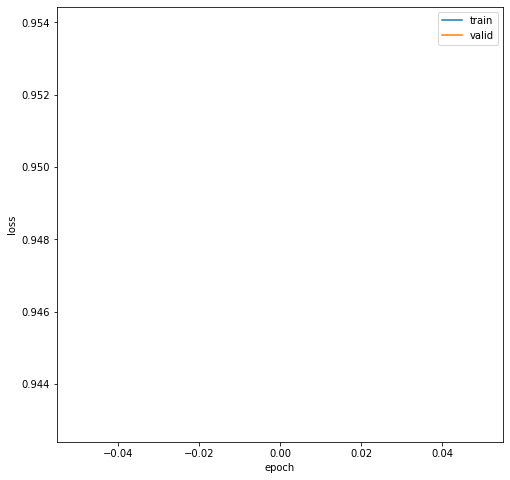

<Figure size 432x288 with 0 Axes>

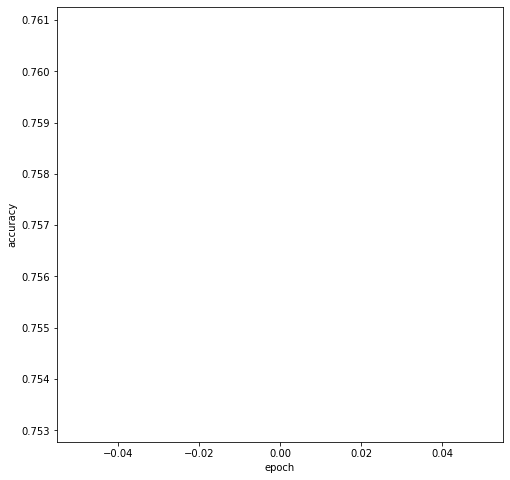

No handles with labels found to put in legend.
train	epoch: 1 loss: 0.842876 accuracy: 0.759160
valid	epoch: 1 loss: 0.832557 accuracy: 0.764618


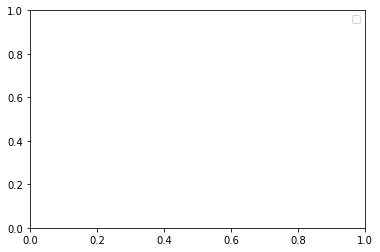

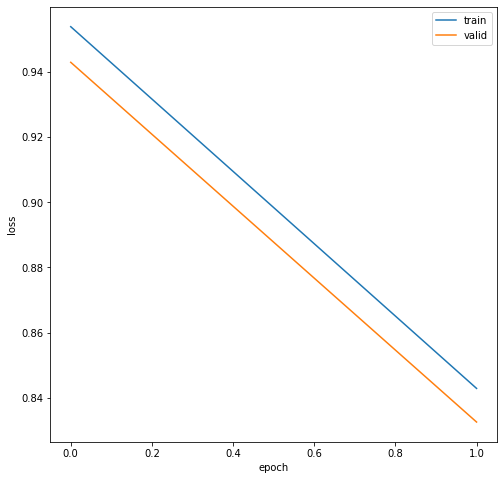

<Figure size 432x288 with 0 Axes>

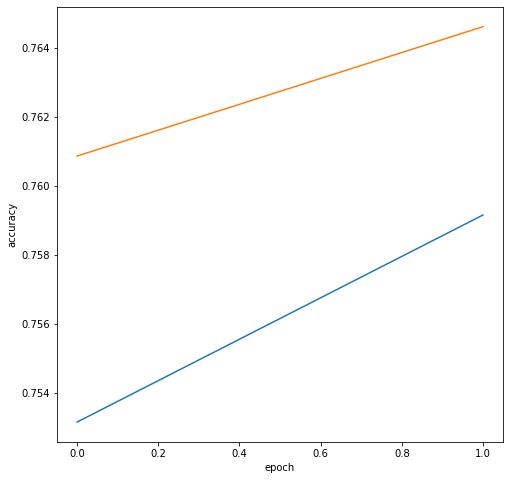

No handles with labels found to put in legend.
train	epoch: 2 loss: 0.775699 accuracy: 0.761597
valid	epoch: 2 loss: 0.767554 accuracy: 0.769865


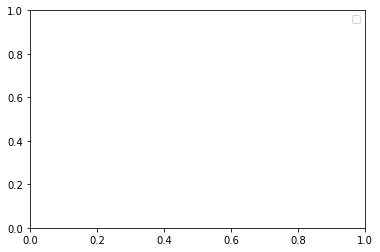

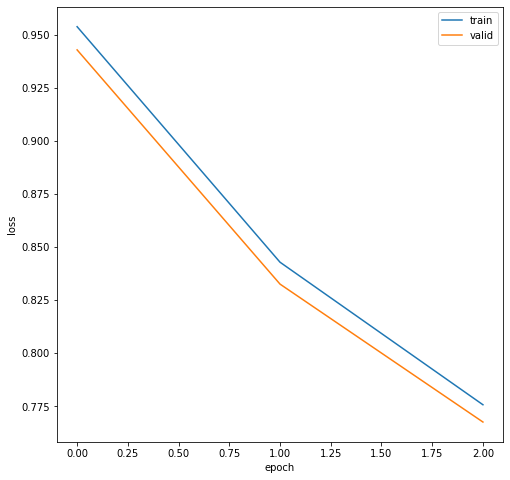

<Figure size 432x288 with 0 Axes>

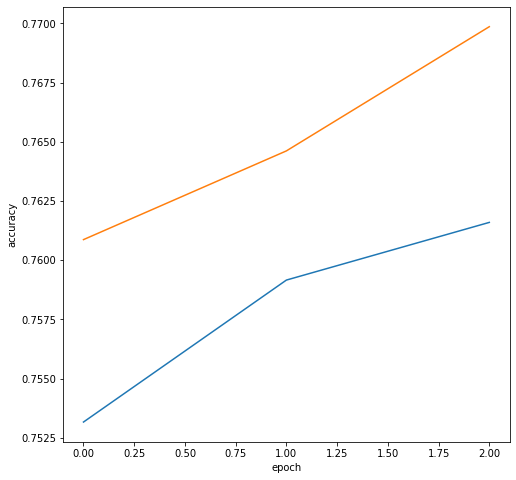

No handles with labels found to put in legend.
train	epoch: 3 loss: 0.728689 accuracy: 0.763565
valid	epoch: 3 loss: 0.722146 accuracy: 0.770615


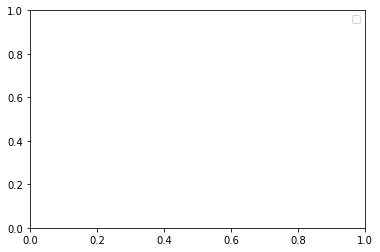

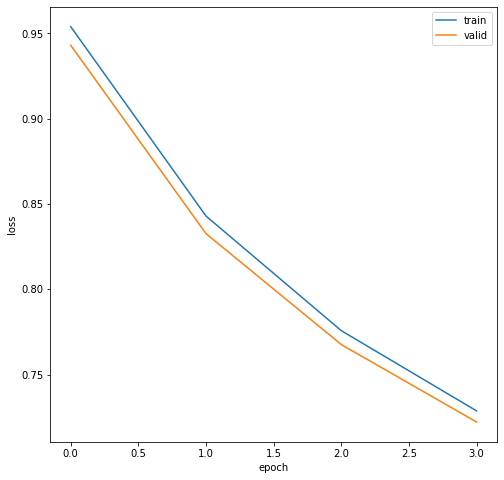

<Figure size 432x288 with 0 Axes>

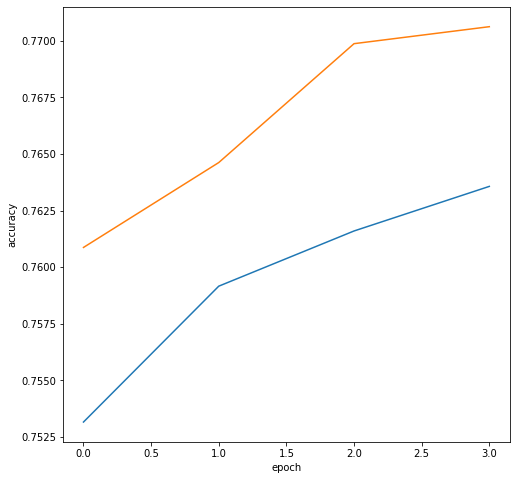

No handles with labels found to put in legend.
train	epoch: 4 loss: 0.692859 accuracy: 0.765439
valid	epoch: 4 loss: 0.687073 accuracy: 0.775112


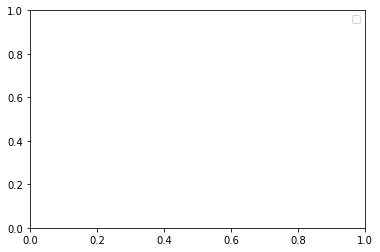

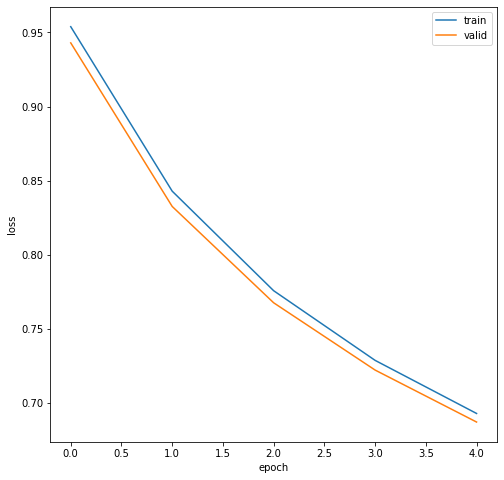

<Figure size 432x288 with 0 Axes>

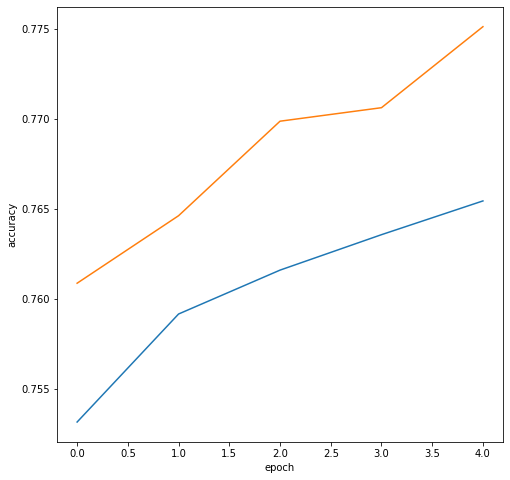

No handles with labels found to put in legend.
train	epoch: 5 loss: 0.664234 accuracy: 0.769469
valid	epoch: 5 loss: 0.659726 accuracy: 0.779610


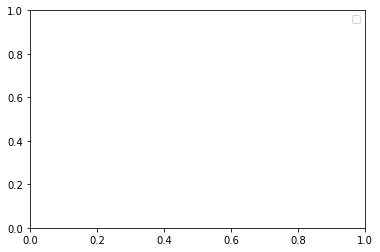

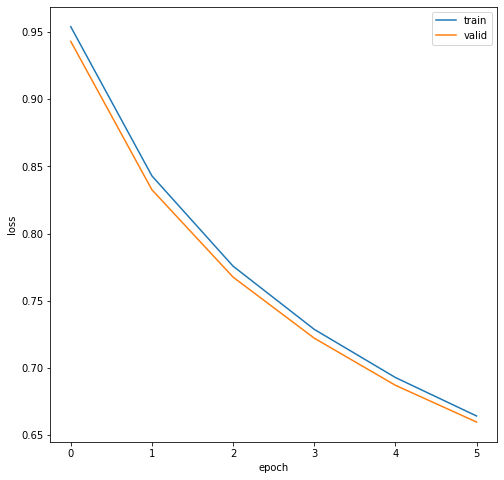

<Figure size 432x288 with 0 Axes>

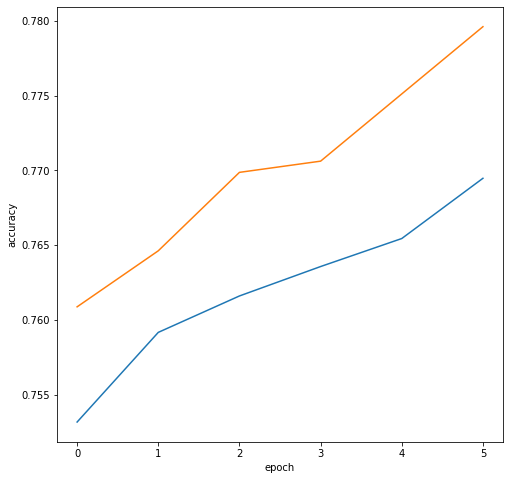

No handles with labels found to put in legend.
train	epoch: 6 loss: 0.640542 accuracy: 0.775373
valid	epoch: 6 loss: 0.637469 accuracy: 0.784108


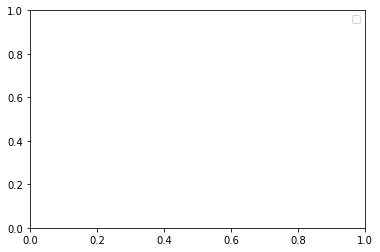

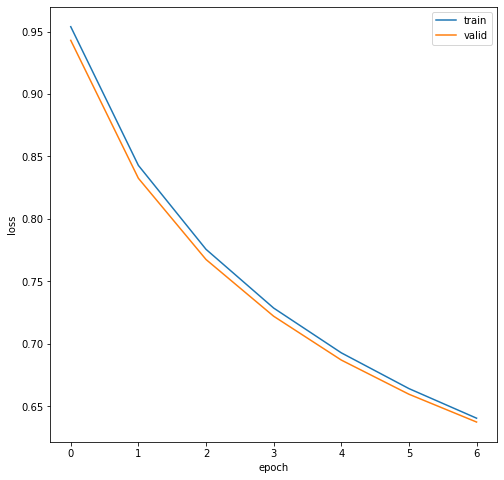

<Figure size 432x288 with 0 Axes>

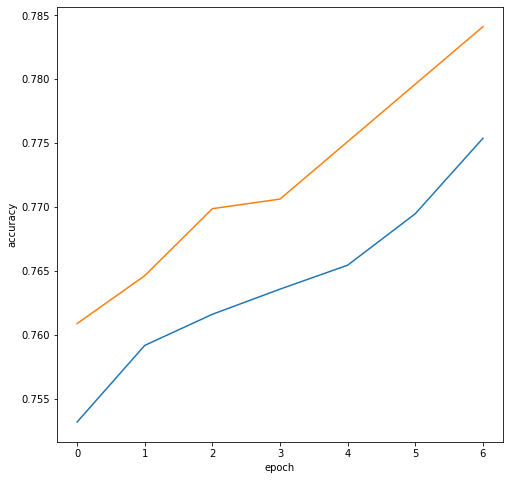

No handles with labels found to put in legend.
train	epoch: 7 loss: 0.620460 accuracy: 0.781745
valid	epoch: 7 loss: 0.618228 accuracy: 0.788606


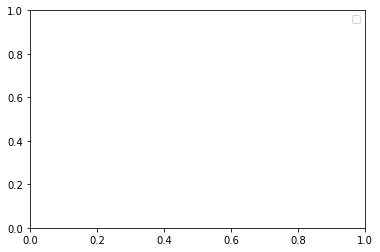

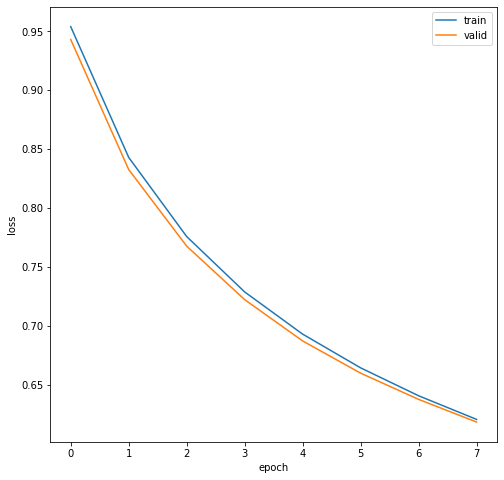

<Figure size 432x288 with 0 Axes>

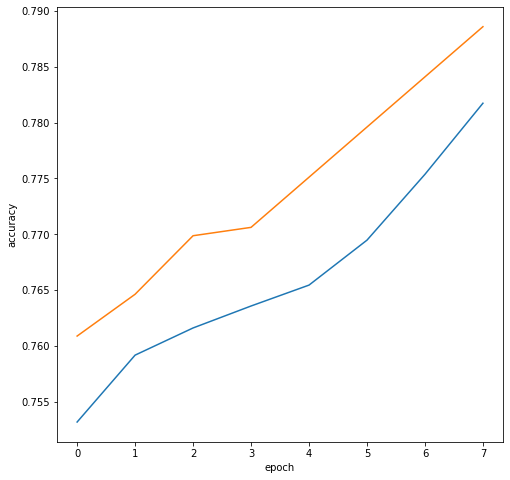

No handles with labels found to put in legend.
train	epoch: 8 loss: 0.603120 accuracy: 0.788024
valid	epoch: 8 loss: 0.601793 accuracy: 0.792354


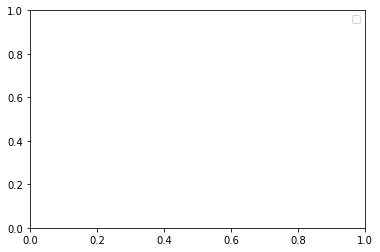

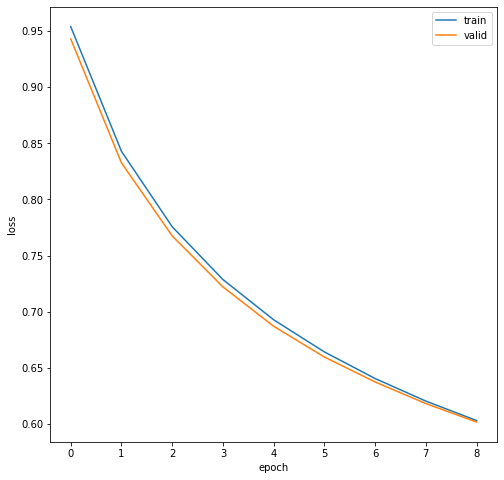

<Figure size 432x288 with 0 Axes>

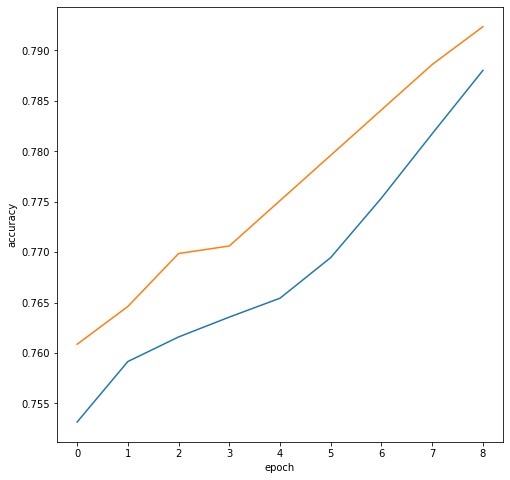

No handles with labels found to put in legend.
train	epoch: 9 loss: 0.587906 accuracy: 0.792897
valid	epoch: 9 loss: 0.587477 accuracy: 0.795352


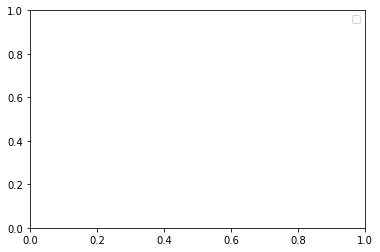

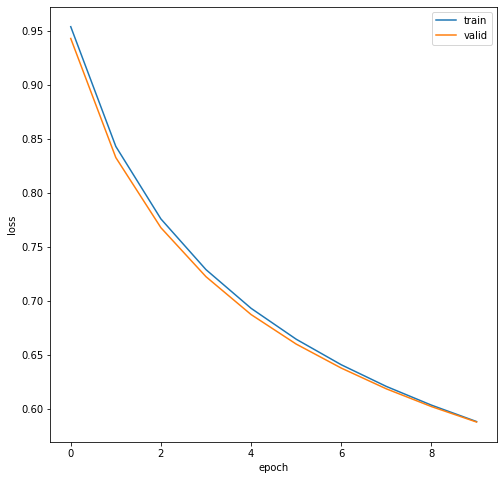

<Figure size 432x288 with 0 Axes>

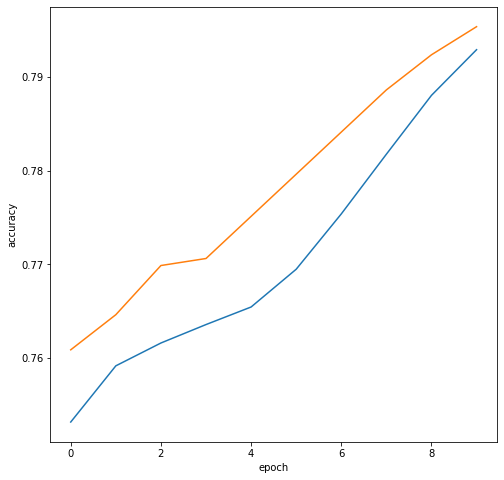

No handles with labels found to put in legend.
Finished Training


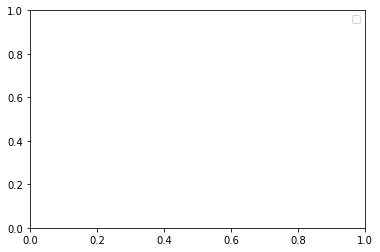

In [169]:
# % matplotlib inline
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import copy
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

X_train = np.load('../../data/nlp2020_70/X_train.npy')
X_valid = np.load('../../data/nlp2020_70/X_valid.npy')
X_test = np.load('../../data/nlp2020_70/X_test.npy')
Y_train = np.load('../../data/nlp2020_70/Y_train.npy')
Y_valid = np.load('../../data/nlp2020_70/Y_valid.npy')
Y_test = np.load('../../data/nlp2020_70/Y_test.npy')

model = Net()
criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失関数
optimizer = optim.SGD(model.parameters(), lr=0.001)  # 確率的勾配降下法

X_train = torch.tensor(X_train, dtype=torch.float32) #float32型にする
Y_train = torch.tensor(Y_train).long() # long型にする
X_valid = torch.tensor(X_valid, dtype=torch.float32) #float32型にする
Y_valid = torch.tensor(Y_valid).long() # long型にする

ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size=1, shuffle=True)

prev_model = copy.deepcopy(model)
prev_optimizer = copy.deepcopy(optimizer)

loss_train_list = []
loss_valid_list = []
acc_train_list = []
acc_valid_list = []


for epoch in range(10):
    for index, data in enumerate(loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if torch.isnan(loss):
            model = prev_model
            optimizer = optim.SGD(model.parameters(), lr=0.001)
            optimizer.load_state_dict(prev_optimizer.state_dict())
        else:
            prev_model = copy.deepcopy(model)
            prev_optimizer = copy.deepcopy(optimizer)

    # train
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    acc = accuracy(outputs, Y_train)
    loss_train_list.append(loss.data.numpy())
    acc_train_list.append(acc)
    print('train\tepoch: %d loss: %f accuracy: %f' % (epoch, loss, acc))

    # valid
    outputs = model(X_valid)
    loss = criterion(outputs, Y_valid)
    acc = accuracy(outputs, Y_valid)
    loss_valid_list.append(loss.data.numpy())
    acc_valid_list.append(acc)
    print('valid\tepoch: %d loss: %f accuracy: %f' % (epoch, loss, acc))

    # plot
    fig = plt.figure(figsize=(8, 8))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(epoch+1), loss_train_list, label="train")
    plt.plot(range(epoch+1), loss_valid_list, label="valid")
    plt.legend()
    plt.show()
    plt.savefig('../nlp75_loss.png')

    fig = plt.figure(figsize=(8, 8))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(range(epoch+1), acc_train_list, label="train")
    plt.plot(range(epoch+1), acc_valid_list, label="valid")
    plt.show()
    plt.legend()
    plt.savefig('../nlp75_accuracy.png')


print('Finished Training')




# 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ

In [ ]:
# % matplotlib inline
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import copy
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

X_train = np.load('../../data/nlp2020_70/X_train.npy')
X_valid = np.load('../../data/nlp2020_70/X_valid.npy')
X_test = np.load('../../data/nlp2020_70/X_test.npy')
Y_train = np.load('../../data/nlp2020_70/Y_train.npy')
Y_valid = np.load('../../data/nlp2020_70/Y_valid.npy')
Y_test = np.load('../../data/nlp2020_70/Y_test.npy')

model = Net()
criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失関数
optimizer = optim.SGD(model.parameters(), lr=0.001)  # 確率的勾配降下法

X_train = torch.tensor(X_train, dtype=torch.float32) #float32型にする
Y_train = torch.tensor(Y_train).long() # long型にする

ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size=1, shuffle=True)

prev_model = copy.deepcopy(model)
prev_optimizer = copy.deepcopy(optimizer)

for epoch in range(10):
    for index, data in enumerate(loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if torch.isnan(loss):
            model = prev_model
            optimizer = optim.SGD(model.parameters(), lr=0.001)
            optimizer.load_state_dict(prev_optimizer.state_dict())
        else:
            prev_model = copy.deepcopy(model)
            prev_optimizer = copy.deepcopy(optimizer)

    torch.save(model.state_dict(), '../nlp76_%d.model' % (epoch))
    torch.save(optimizer.state_dict(), '../nlp76_%d.palams' % (epoch))
    print('epoch: %d loss: %f accuracy: %f' % (epoch, loss, acc))

print('Finished Training')


In [ ]:
model = torch.load('../nlp760.model')
model
'''
odict_items([
('fc.weight', 
tensor([[-0.1008, -0.1395, -0.1014,  ..., -0.0492,  0.1527, -0.2046],
        [ 0.1128, -0.1131,  0.0435,  ...,  0.0622,  0.0962, -0.0228],
        [-0.1079,  0.1268, -0.0365,  ..., -0.0685, -0.1348,  0.0695],
        [-0.0075,  0.0643,  0.0924,  ...,  0.1210,  0.0523,  0.0239]])), 
('fc.bias', tensor([ 0.4536, -0.3080,  0.4848, -0.6180]))])
'''

params = torch.load('../nlp760.palams')
params
'''
{'state': {},
 'param_groups': [{'lr': 0.001,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'params': [10752651200, 10752656896]}]}
'''

# 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [ ]:
# % matplotlib inline
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import copy
import numpy as np
import matplotlib.pyplot as plt
import time


X_train = np.load('../../data/nlp2020_70/X_train.npy')
X_valid = np.load('../../data/nlp2020_70/X_valid.npy')
X_test = np.load('../../data/nlp2020_70/X_test.npy')
Y_train = np.load('../../data/nlp2020_70/Y_train.npy')
Y_valid = np.load('../../data/nlp2020_70/Y_valid.npy')
Y_test = np.load('../../data/nlp2020_70/Y_test.npy')

model = Net()
criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失関数
optimizer = optim.SGD(model.parameters(), lr=0.001)  # 確率的勾配降下法

X_train = torch.tensor(X_train, dtype=torch.float32) #float32型にする
Y_train = torch.tensor(Y_train).long() # long型にする


prev_model = copy.deepcopy(model)
prev_optimizer = copy.deepcopy(optimizer)

times = []

ds = TensorDataset(X_train, Y_train)

for bach in [2**x for x in range(10)]:
    loader = DataLoader(ds, batch_size=bach, shuffle=True)
    start = time.time()

    for epoch in range(1):
        for index, data in enumerate(loader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if torch.isnan(loss):
                model = prev_model
                optimizer = optim.SGD(model.parameters(), lr=0.001)
                optimizer.load_state_dict(prev_optimizer.state_dict())
            else:
                prev_model = copy.deepcopy(model)
                prev_optimizer = copy.deepcopy(optimizer)

    times.append(time.time() - start)
    print('epoch: %d loss: %f accuracy: %f' % (epoch, loss, acc))

print('Finished Training')

times

'''
[5.0293779373168945,
 2.6831369400024414,
 1.2833211421966553,
 0.7357909679412842]
'''

In [ ]:
times

# 78. GPU上での学習Permalink
問題77のコードを改変し，GPU上で学習を実行せよ．

# 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [156]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(300, 128) # 重みを作成
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)
        nn.init.xavier_uniform_(self.fc1.weight) # 一様分布の乱数で重みを初期化
        nn.init.xavier_uniform_(self.fc2.weight) # 一様分布の乱数で重みを初期化
    
    def forward(self, x): 
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

In [158]:
# % matplotlib inline
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import copy
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

X_train = np.load('../../data/nlp2020_70/X_train.npy')
X_valid = np.load('../../data/nlp2020_70/X_valid.npy')
X_test = np.load('../../data/nlp2020_70/X_test.npy')
Y_train = np.load('../../data/nlp2020_70/Y_train.npy')
Y_valid = np.load('../../data/nlp2020_70/Y_valid.npy')
Y_test = np.load('../../data/nlp2020_70/Y_test.npy')

model = Net()
criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失関数
optimizer = optim.SGD(model.parameters(), lr=0.001)  # 確率的勾配降下法

X_train = torch.tensor(X_train, dtype=torch.float32) #float32型にする
Y_train = torch.tensor(Y_train).long() # long型にする
X_valid = torch.tensor(X_valid, dtype=torch.float32) #float32型にする
Y_valid = torch.tensor(Y_valid).long() # long型にする

ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size=8, shuffle=True)

prev_model = copy.deepcopy(model)
prev_optimizer = copy.deepcopy(optimizer)

loss_train_list = []
loss_valid_list = []
acc_train_list = []
acc_valid_list = []
times = []

start = time.time()
for epoch in range(100):
    for index, data in enumerate(loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if torch.isnan(loss):
            model = prev_model
            optimizer = optim.SGD(model.parameters(), lr=0.001)
            optimizer.load_state_dict(prev_optimizer.state_dict())
        else:
            prev_model = copy.deepcopy(model)
            prev_optimizer = copy.deepcopy(optimizer)

    times.append(time.time() - start)

    # train
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    acc = accuracy(outputs, Y_train)
    loss_train_list.append(loss.data.numpy())
    acc_train_list.append(acc)
    print('train\tepoch: %d loss: %f accuracy: %f' % (epoch, loss, acc))

    # valid
    outputs = model(X_valid)
    loss = criterion(outputs, Y_valid)
    acc = accuracy(outputs, Y_valid)
    loss_valid_list.append(loss.data.numpy())
    acc_valid_list.append(acc)
    print('valid\tepoch: %d loss: %f accuracy: %f' % (epoch, loss, acc))

    # plot
    fig = plt.figure(figsize=(5, 5))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(20), loss_train_list, label="train")
    plt.plot(range(20), loss_valid_list, label="valid")
    plt.legend()
    plt.show()
    plt.savefig('../nlp79_loss.png')

    fig = plt.figure(figsize=(5, 5))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(range(20), acc_train_list, label="train")
    plt.plot(range(20), acc_valid_list, label="valid")
    plt.legend()
    plt.show()
    plt.savefig('../nlp79_accuracy.png')

        

print('Finished Training')


train	epoch: 0 loss: 1.178246 accuracy: 0.676694
valid	epoch: 0 loss: 1.172315 accuracy: 0.682909
train	epoch: 1 loss: 1.079278 accuracy: 0.729266
valid	epoch: 1 loss: 1.069315 accuracy: 0.742129
train	epoch: 2 loss: 1.014512 accuracy: 0.744822
valid	epoch: 2 loss: 1.002737 accuracy: 0.754123
train	epoch: 3 loss: 0.958174 accuracy: 0.751195
valid	epoch: 3 loss: 0.945584 accuracy: 0.761619
train	epoch: 4 loss: 0.906632 accuracy: 0.753725
valid	epoch: 4 loss: 0.894110 accuracy: 0.764618
train	epoch: 5 loss: 0.860301 accuracy: 0.756349
valid	epoch: 5 loss: 0.847741 accuracy: 0.766117
train	epoch: 6 loss: 0.819933 accuracy: 0.758223
valid	epoch: 6 loss: 0.808048 accuracy: 0.766867
train	epoch: 7 loss: 0.785309 accuracy: 0.760753
valid	epoch: 7 loss: 0.774024 accuracy: 0.768366
train	epoch: 8 loss: 0.755824 accuracy: 0.762159
valid	epoch: 8 loss: 0.745185 accuracy: 0.771364
train	epoch: 9 loss: 0.730695 accuracy: 0.763377
valid	epoch: 9 loss: 0.720676 accuracy: 0.771364
train	epoch: 10 loss

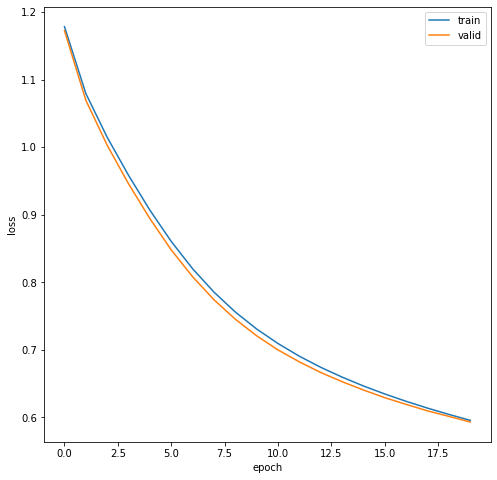

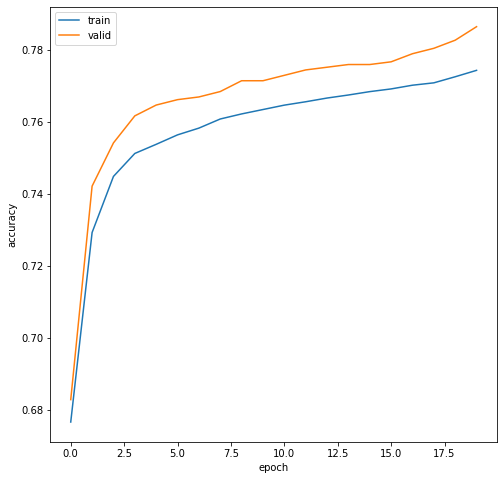

In [162]:


fig = plt.figure(figsize=(8, 8))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(20), loss_train_list, label="train")
plt.plot(range(20), loss_valid_list, label="valid")
plt.legend()
plt.savefig('../nlp79_loss.png')

fig = plt.figure(figsize=(8, 8))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(range(20), acc_train_list, label="train")
plt.plot(range(20), acc_valid_list, label="valid")
plt.legend()
plt.savefig('../nlp79_accuracy.png')
